# PHASE 6. SEPSIS - SURVIVAL ANALYSIS (SCI-KIT LEARN)

* In this notebook, we will be trying out different Cox regression models and evaluating their performance. The same features used in the preliminary Cox regression models from the notebook *"SEPSIS - Insight Project (Patch'd Inc.)"* are used in the model fitting below. 
* The models used in this include:
    * Cox regression (using the full data)
    * Cox regression with undersampling
    * Cox regression using Gradient Boosting
        * **hyperparameter searching is done, systematically**
    * Cox regression using XGBOOST
        * No hyperparamater searching is done
        * XGBoost is used as a means of deriving feature importances
* At the bottom of this notebook, we perform feature selection to identify only important features
* The Cox and Gradient Boosted Models (best version) were repeated using only those features identified as important in a univariate feature selection process (at the bottom of this notebook)

In [1]:
# Import all necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Import the training and testing data
* This is the same training and testing data we processed from the first notebook *"SEPSIS - Insight Project (Patch'd Inc.)"*
* We have retained the same training and testing data here, because, data was imputed and outliers removed, specific to the distributions of the training and testing sets - thus, the testing set is completely independent from the training data to prevent any data leakage. 

In [2]:
# Import the training and testing datasets

train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
train.head()
test.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,sepsis,factor1,factor2,factor3,factor4,event_time_hrs,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!UsRpFErA8,0.541348,1.297201,0.473352,-0.057729,0.798717,1.709847,0.311190,0.409040,0.275108,0.314789,0.162162,2.110612e-01,5.878398e-01,0.573000,9.840689e-01,1.0,0.0,-0.358733,-0.504876,-0.267494,-0.437074,88.516667,-1.023647,-0.126636,0.163962,0.740871,0.0,0.0,0.0,1.0,0.0,-0.509618,0.000000,-0.057659,-0.018150,-0.023585,-0.009350,-3.389428e-02,-5.674046e-02,-0.033039,-0.160422,-0.208454,-0.082641,-5.014988e-01,-0.292011,2.891594e-02,0.016837,0.029384
!!bL3J70vVe,-0.656728,-0.120173,0.162162,0.288647,0.798717,0.134988,-0.622380,-0.043174,-1.189206,-0.060178,0.265892,3.319649e-01,4.313565e-01,0.179796,3.213956e-01,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,24.033333,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-2.151583,0.107722,-0.863220,0.051947,0.037268,-0.229523,-3.723557e-01,-2.774352e-01,-0.155204,0.129478,0.092892,-0.572088,-6.915094e-01,-0.386847,5.969249e-01,0.333934,1.857290
!0BTVPHmdoe,0.541348,0.689755,-3.572117,0.492624,0.000000,-0.742434,-4.667849,-0.625599,0.541348,0.944732,-1.290058,3.814737e-01,0.000000e+00,0.553408,1.734494e+00,0.0,0.0,-0.352667,-0.065079,-0.212924,-0.392156,24.400000,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,-0.219116,0.000000,-0.057659,-0.054472,0.036071,0.074383,-0.000000e+00,-1.000093e-01,-0.031909,-0.207006,0.137079,0.282672,-3.800557e-01,-0.121261,2.191364e-02,0.006992,0.012634
!1G8Qg@dzij,-0.057690,0.464775,0.162162,0.000000,0.000000,1.529863,0.000000,-1.794298,-0.057690,-0.300157,0.162162,2.402672e-08,1.511500e-08,0.572422,1.084501e-08,0.0,0.0,-0.335162,-0.119248,-0.010803,-0.320071,94.600000,0.116132,-0.218831,0.246376,-0.174987,0.0,0.0,0.0,0.0,0.0,0.709247,-0.230558,-0.460440,0.138204,0.826166,-0.074666,-6.959543e-09,-4.993473e-09,-0.263566,-0.212885,-1.272600,0.115013,7.691787e-09,0.405989,-3.541604e-09,-0.186933,-0.326565
!1TBKMu!Enq,0.141989,2.152124,-0.771408,0.032072,0.110933,-0.124989,-0.518650,-0.309370,0.086523,2.214619,-0.512083,1.200020e-02,4.150730e-02,0.046767,1.940610e-01,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,137.750000,1.366033,-0.427679,0.238288,-0.167490,0.0,0.0,0.0,0.0,0.0,0.651804,0.828794,-0.863220,-1.911704,0.267055,0.442040,-3.582994e-02,-1.675174e-01,-0.040370,1.443497,-0.201649,-0.333778,1.264897e-01,0.030483,-1.091885e-01,-0.026313,-0.562650


In [3]:
# Below, we just confirm, whether any of the ID values of the test data are in the training data 
# AS shown below - NO, there are none!

testids = (test.index).values
train.index.isin(testids).sum()

0

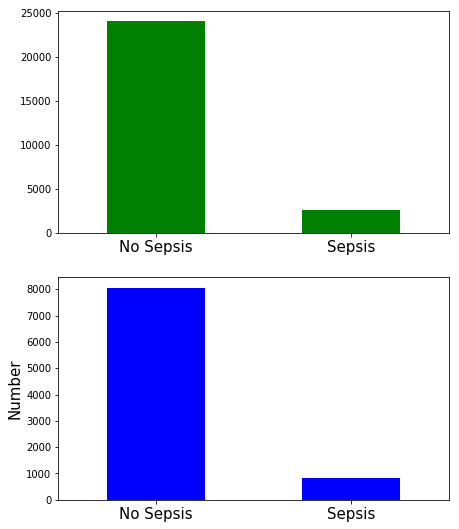

In [1155]:
# Plot showing the distribution of sepsis versus no-sepsis in the training and testing datasets

fig, ax = plt.subplots(2,1, figsize=(7,9))
train['sepsis'].value_counts().plot(kind="bar", ax = ax[0], color="green")
plt.ylabel("Number", fontsize=15)
ax[0].set_xticklabels(["No Sepsis","Sepsis"], rotation=0, fontsize=15)

test['sepsis'].value_counts().plot(kind="bar", ax = ax[1], color="blue")
plt.ylabel("Number", fontsize=15)
ax[1].set_xticklabels(["No Sepsis","Sepsis"], rotation=0, fontsize=15)

plt.show()

### Prepare the data for Cox regression

In [5]:
# Split the training data and testing data into the Features and Target datasets (X, y)

X_train = train.drop(["sepsis","event_time_hrs"], axis=1)
y_train = train[["sepsis","event_time_hrs"]]
X_test = test.drop(["sepsis","event_time_hrs"], axis=1)
y_test = test[["sepsis","event_time_hrs"]]

# sksurv prefers the outcome to be a structured array, of outcome (as Boolean), and event time (e.g., (True, 5))
# So first, we replace 0/1 into True/False
y_train["sepsis"] = y_train['sepsis'].replace({0:False,1:True})
y_test["sepsis"] = y_test['sepsis'].replace({0:False,1:True})

In [8]:
# Now, use the "Surv.from_dataframe" function to put the y data into the right format 
# i.e., (structured array - of event occurrence with event time)
# Do this for both train and testing datasets

y_train_array = Surv.from_dataframe("sepsis","event_time_hrs",y_train)
y_test_array = Surv.from_dataframe("sepsis","event_time_hrs",y_test)

### Run the Cox regression - BASELINE MODEL
* In this model, we will use only the vital signs at event occurrence, age, sex, and BMI as features and examine performance


In [9]:
X_train_simple = X_train[['respiratory_rate', 'map', 'spo2','age', 'bmi',
                         'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0']]

X_test_simple = X_test[['respiratory_rate', 'map', 'spo2','age', 'bmi',
                         'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0']]

cph_simple = CoxPHSurvivalAnalysis()
cph_simple.fit(X_train_simple, y_train_array)

# Get predicted values and evaluation metrics

preds_simple = cph_simple.predict(X_test_simple)
# Get concordance
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds_simple)
print(result[0])


from sksurv.metrics import cumulative_dynamic_auc

coxsimple_aucs = cumulative_dynamic_auc(survival_train = y_train_array, 
                       survival_test = y_test_array, 
                       estimate = preds_simple, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

coxsimple_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "Cox, baseline":coxsimple_aucs[0]})
coxsimple_auc_df.set_index("times", inplace=True)
display(np.round(cox_auc_df,3).T)

fig, ax = plt.subplots(1,1, figsize=(8,5))
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")
ax.set_ylim(0.5,0.9)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()

0.6419725611198304


NameError: name 'cox_auc_df' is not defined

### Run the Cox regression (using Sk Survival regression)

In [11]:
# Set up the model using default parameters 
# Fit the model 

cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train_array)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [12]:
# Create a data frame of the coefficients
results_df = pd.DataFrame(cph.coef_, index=X_train.columns, columns = ["Coefficient"])
results_df = results_df.sort_values(by = "Coefficient", ascending = False)
results_df

,Coefficient
map_sd,0.786410
spo2_sd,0.459121
heart_rate_mean,0.427425
charlson_index,0.404813
spo2_mean,0.385402
respiratory_rate_sd,0.184580
spo2,0.177436
medfactor2,0.176863
charlson_index*map_sd*age,0.161157
medfactor3,0.154230


#### Get evaluation metrics 
* We will calculate concordance - percentage of sepsis/nonsepsis pairs, where the model correctly predicted the septic person to have the HIGHER RISK SCORE, compared to the non-septic patient
* Formal definition: The Concordance statistic is an estimated conditional probability that for any pair of “case” and “control,” the predicted risk of an event is higher for the “case”
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079915/

In [13]:
# Predict concordance 

preds = cph.predict(X_test)
# Get concordance
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.7497615002179199

* The second statistic we will calculate is the time-dependent ROC-AUC (also called the cumulative dependent ROC-AUC curve)
* Time-dependent ROC curves and the AUC metric, evaluates how well the fitted model can discriminate between patients that experienced sepsis versus those that did not experience sepsis, up to the specified time point (i.e., the time point, until sepsis occurrence)
* Below, we calculate the AUC/ROC at time points - from 5h to 24h before event ocurrence
* And then plot the AUC over time
* Can see that AUC is quite

times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr
"Cox, full sample",0.847,0.792,0.813,0.787,0.782,0.773,0.774,0.775,0.774,0.776,0.78,0.774,0.769,0.769,0.766,0.766,0.765,0.765,0.765,0.764


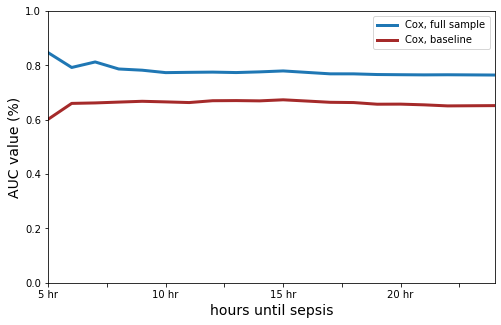

In [14]:
from sksurv.metrics import cumulative_dynamic_auc

cox_aucs = cumulative_dynamic_auc(survival_train = y_train_array, 
                       survival_test = y_test_array, 
                       estimate = preds, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

cox_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "Cox, full sample":cox_aucs[0]})
cox_auc_df.set_index("times", inplace=True)
display(np.round(cox_auc_df,3).T)


fig, ax = plt.subplots(1,1, figsize=(8,5))
cox_auc_df.plot(ax = ax, linewidth=3)
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")
ax.set_ylim(0.0,1.0)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()

#### Get the predicted survival functions of all patients

In [15]:
# We can use the predict_survival_function for this
# first concatenate the training and testing datasets
X = pd.concat([X_train, X_test])
X.head()
survival_functions = cph.predict_survival_function(X)


In [20]:
survival_functions[0].y
all_functions = [list(survival_functions[i].y) for i in np.arange(survival_functions.shape[0])]

### Try accelerated failure-time model (Weibull)
* I will try another standard Survival analysis model used in the literature - the parametric survival model (or accelerated failure time model)

'the concordance of the weibull model is 0.44048144718317744'

times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr
weibull,0.381,0.386,0.384,0.407,0.407,0.41,0.416,0.418,0.417,0.419,0.42,0.419,0.425,0.426,0.425,0.429,0.435,0.44,0.436,0.434


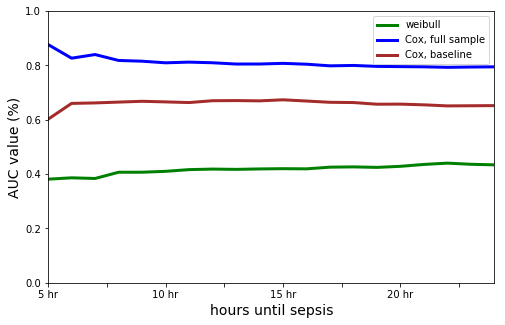

In [1234]:
from sksurv.linear_model import IPCRidge
weibull = IPCRidge()
weibull.fit(X_train, y_train_array)

# Get concordance
preds_weibull = weibull.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds_weibull)
display("the concordance of the weibull model is {}".format(result[0]))

from sksurv.metrics import cumulative_dynamic_auc

# Get the cumulative dynamic ROC
weibull_aucs = cumulative_dynamic_auc(survival_train = y_train_array, 
                       survival_test = y_test_array, 
                       estimate = preds_weibull, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

weibull_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "weibull":weibull_aucs[0]})
weibull_auc_df.set_index("times", inplace=True)
display(np.round(weibull_auc_df,3).T)


fig, ax = plt.subplots(1,1, figsize=(8,5))
weibull_auc_df.plot(ax = ax, color = "green", linewidth=3)
cox_auc_df.plot(ax = ax, color = "blue", linewidth = 3)
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")

ax.set_ylim(0.0,1)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()
ax.legend()

* We can see this model has extremely poor performance compared to the Cox model

## 2. Try Undersampling the majority class

* Prepare the dataset to undersample the minority class (i.e., "non-sepsis") - we need to ensure that the Y data frame includes ONLY the sepsis column
* We must transfer the "time_hrs" column to the X dataset
* Undersampling only works when the y dataset consists of a single binary column

In [1181]:
X_smote = X_train.copy()
y_smote = y_train.copy()

# Now transfer the "event_time_hrs" to the X_smote dataset
X_smote["event_time_hrs"] = y_train["event_time_hrs"]

# Drop ["event_time_hrs"] from the y_smote datasets
y_smote = y_smote.drop("event_time_hrs", axis=1)

# View the datasets needed for undersampling

display(X_smote.head())
display(y_smote.head())

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age,event_time_hrs
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!AScBQ5btA,-1.260806,0.907276,1.110646,-0.831246,-5.049391,0.234658,0.237634,1.201476,1.768828,0.840231,0.939022,0.424713,2.103846,0.085466,0.116596,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.533510,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,-0.739717,-1.057747,-0.826689,-1.852169,-0.102648,-0.075242,-1.932660,-2.763579,-2.159893,-0.268189,-0.196585,0.236106,0.173068,2.024992,69.000000
!!G4BY3c@tP,-0.856855,0.013341,1.110646,0.058333,-1.615805,0.335226,0.316846,0.683770,-0.587554,-0.057429,0.846608,0.822820,1.019260,0.463946,0.370407,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,-0.423578,0.000000,-0.880373,0.050559,-0.601973,-0.745331,-0.897329,-0.326096,-0.408446,0.024326,-0.289630,-0.358605,-0.156896,-0.196517,0.138127,0.173009,0.372907,14.900000
!!rmvMcfsDP,-0.250928,-0.612414,-0.473582,0.000000,0.000000,0.134090,0.950537,-0.920389,-0.301422,-0.690633,-0.975254,0.087823,0.199435,0.203726,0.452731,1.0,2.720469,1.126702,0.136875,0.481550,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,0.292070,0.426203,0.710485,-0.490684,-0.653922,-0.692903,0.141695,0.321658,0.144744,-0.201713,-0.268818,-0.284842,0.132229,0.059502,0.093947,0.042275,0.207511,302.000000
!0KLAkVXUQU,-1.664758,1.667121,-0.790427,0.408332,-1.090669,1.202343,-0.792114,-0.016226,-1.294469,0.821607,-0.394370,0.144857,0.491705,0.434966,0.296382,1.0,-0.358990,0.256240,3.778535,1.934842,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-0.707723,0.138286,1.108199,0.910504,-0.017982,-0.437041,0.544907,0.328450,0.482028,-0.581470,0.011484,0.279105,-0.209756,-0.307835,-0.232452,-0.341142,-0.784297,13.500000
!0L@GS!mAgr,1.970804,0.169780,0.793801,1.574993,2.423708,0.648103,-0.158423,0.168495,0.388661,-0.595652,0.833407,0.734163,0.924834,0.421180,0.066273,1.0,-0.296202,-0.495406,-0.209707,-0.512547,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,1.0,0.0,-1.080571,0.766675,-0.482659,0.287497,-0.081326,-0.402251,-0.446379,-0.031987,-0.203286,0.643645,-0.182071,-0.900555,-0.071613,-0.455115,0.034564,0.219665,0.521547,15.616667


,sepsis
patient_id,
!!AScBQ5btA,False
!!G4BY3c@tP,False
!!rmvMcfsDP,False
!0KLAkVXUQU,False
!0L@GS!mAgr,False


In [1182]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Set up RandomUndersampler object
rus = RandomUnderSampler(random_state=0)

# Fit the undersampler
X_tr_resampled, y_tr_resampled = rus.fit_resample(X_smote, y_smote)
print(sorted(Counter(y_resampled).items()))

# Convert the resampled datasets into data frames
X_tr_resampled_df = pd.DataFrame(X_tr_resampled, columns = X_smote.columns)
y_tr_resampled_df = pd.DataFrame(y_tr_resampled, columns = ["sepsis"])

# Return event time to the y dataset, and drop it from the X dataset
y_tr_resampled_df["event_time_hrs"] = X_tr_resampled_df["event_time_hrs"]
X_tr_resampled_df = X_tr_resampled_df.drop("event_time_hrs", axis=1)

display(X_tr_resampled_df.shape)
display(y_tr_resampled_df.shape)

# The steps below convert the TIME and EVENT columns into a format for SURVIVAL REGRESSION
y_train_resampled_df_proper = Surv.from_dataframe("sepsis","event_time_hrs",y_tr_resampled_df)

# Fit the model
cph_usample = CoxPHSurvivalAnalysis()
cph_usample.fit(X_tr_resampled_df, y_train_resampled_df_proper)

[(False, 2592), (True, 2592)]


(5184, 46)

(5184, 2)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [1183]:
# Fit the model
cph_usample = CoxPHSurvivalAnalysis()
cph_usample.fit(X_tr_resampled_df, y_train_resampled_df_proper)

# View the resampled dataset (training data)
X_tr_resampled_df.head()


,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
0,-0.250928,1.220153,1.110646,0.656247,0.000000,0.949806,0.000000,1.065366,-0.250928,0.745250,0.978627,0.245545,5.494014e-09,0.355385,0.129352,0.0,0.000000,0.000000,0.032414,0.000000,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-1.901117,-1.185134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.416809,-2.025386,-1.860486,-0.245913,-0.675628,-0.000000,-0.000000,-0.000000
1,0.153023,-0.511846,-1.107273,1.691659,0.000000,1.195638,-0.633691,0.849047,0.455987,-0.812618,-1.054465,1.074131,3.318799e-01,0.754423,0.370407,0.0,-0.371272,1.251742,-0.174677,0.122957,-0.344934,-0.133357,0.291901,-0.180172,0.0,0.0,0.0,0.0,0.0,0.494615,0.010985,1.505913,-1.223732,1.278592,-1.587933,0.499782,0.557801,1.136095,-0.401933,0.419952,-0.521555,0.183209,0.373149,0.275897,0.561930,0.744848
2,-0.250928,1.533031,0.160110,0.233332,0.605927,1.966657,0.316846,-0.910667,-0.621217,0.586949,-0.156736,0.282780,1.985809e-01,1.082794,0.400782,1.0,-0.365641,1.246824,-0.105836,0.129537,1.917461,-0.290672,0.456843,-0.250721,0.0,0.0,0.0,0.0,0.0,0.265074,1.798729,0.710485,0.417018,-0.647015,-0.111359,0.141089,0.284749,0.769308,0.155585,-0.241394,-0.041547,0.106237,0.287021,0.075480,0.203924,0.188331
3,-0.654879,0.147431,-0.156736,-0.174999,-0.807903,-1.407948,0.950537,0.231689,0.068867,1.795624,-0.499985,0.091150,3.636497e-01,0.902415,0.380435,1.0,-0.353102,-0.509795,-0.198653,-0.430495,1.298395,-0.352619,0.830693,-0.151405,0.0,0.0,0.0,0.0,0.0,1.462180,1.905725,-0.880373,-1.580819,-0.203973,0.440174,-0.320147,-0.334924,-0.794462,2.625526,0.338771,-0.731069,0.556264,1.319494,-0.489720,-1.161647,-1.287264
4,-0.250928,0.370915,0.160110,0.000000,0.100988,1.340903,-0.158423,-0.852334,-0.537060,-0.266014,-0.077525,0.071443,2.885967e-01,0.742525,0.599081,0.0,-0.353102,-0.509795,-0.198653,-0.430495,0.781794,-0.335951,-0.345104,-0.225125,0.0,0.0,0.0,0.0,0.0,0.436089,1.979225,-0.880373,0.234191,0.750372,0.068251,-0.254073,-0.527415,-0.653699,-0.116006,-0.371694,-0.033808,0.261253,0.323807,-0.230000,-0.285071,-0.383921


0.747756368116733


times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr
"Cox, with random undersampling",0.854,0.798,0.812,0.785,0.782,0.775,0.776,0.776,0.775,0.776,0.779,0.774,0.768,0.768,0.766,0.764,0.763,0.763,0.763,0.763


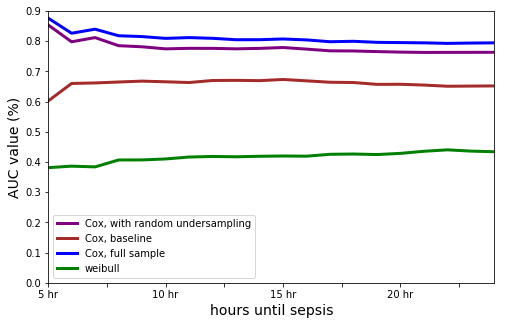

In [1273]:
# Get concordance
pred_usample = cph_usample.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], pred_usample)
print(result[0])

# Get the cumulative dynamic ROC
usample_aucs = cumulative_dynamic_auc(survival_train = y_train_array, 
                       survival_test = y_test_array, 
                       estimate = pred_usample, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

usample_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "Cox, with random undersampling":usample_aucs[0]})
usample_auc_df.set_index("times", inplace=True)
display(np.round(usample_auc_df,3).T)

fig, ax = plt.subplots(1,1, figsize=(8,5))
# Plot the AUCs against time
usample_auc_df.plot(ax = ax, color = "purple", linewidth=3)
# Include the AUCs from the two previous models
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")
cox_auc_df.plot(ax = ax, color = "blue", linewidth = 3)
weibull_auc_df.plot(ax = ax, color = "green", linewidth=3)
ax.set_ylim(0,0.9)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()

* We can see that with undersampling - the discrimination performance is comparable to using the full sample

### Try another form of Undersampling: ClusterCentroids

In [1174]:
from imblearn.under_sampling import ClusterCentroids

X_smote = X_train.copy()
y_smote = y_train.copy()

# Now transfer the "event_time_hrs" to the X_smote dataset
X_smote["event_time_hrs"] = y_train["event_time_hrs"]

# Drop ["event_time_hrs"] from the y_smote datasets
y_smote = y_smote.drop("event_time_hrs", axis=1)

# Get cluster centroids object
# This method will synthetically create people in the "non_sepsis" class using cluster centroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_smote, y_smote)


In [1175]:
# Convert the resampled datasets into data frames
X_tr_resampled_df = pd.DataFrame(X_resampled, columns = X_smote.columns)
y_tr_resampled_df = pd.DataFrame(y_resampled, columns = ["sepsis"])

# Transfer the "event_time_hrs" back to the y dataset
y_tr_resampled_df["event_time_hrs"] = X_tr_resampled_df["event_time_hrs"]
X_tr_resampled_df = X_tr_resampled_df.drop("event_time_hrs", axis=1)

In [1176]:
# The steps below convert the TIME and EVENT columns into a format for SURVIVAL REGRESSION
y_train_resampled_df_proper = Surv.from_dataframe("sepsis","event_time_hrs",y_tr_resampled_df)

# Fit the model
cph_usample2 = CoxPHSurvivalAnalysis()
cph_usample2.fit(X_tr_resampled_df, y_train_resampled_df_proper)



CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

The concordance of the Cluster centroid undersampled Cox regression model is 0.7053778144615629


times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr
"Cox, with cluster centroid undersampling",0.732,0.739,0.753,0.74,0.74,0.73,0.729,0.735,0.734,0.735,0.735,0.729,0.725,0.725,0.723,0.721,0.722,0.723,0.724,0.727


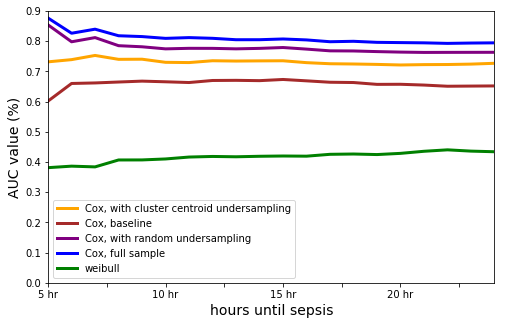

In [1236]:
# Get the concordance rate
pred_usample2 = cph_usample2.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], pred_usample2)
print("The concordance of the Cluster centroid undersampled Cox regression model is {}".format(result[0]))

# Get the cumulative dynamic ROC
usample2_aucs = cumulative_dynamic_auc(survival_train = y_train_array, 
                       survival_test = y_test_array, 
                       estimate = pred_usample2, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

usample2_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "Cox, with cluster centroid undersampling":usample2_aucs[0]})
usample2_auc_df.set_index("times", inplace=True)
display(np.round(usample2_auc_df,3).T)

fig, ax = plt.subplots(1,1, figsize=(8,5))
# Plot the AUCs against time
usample2_auc_df.plot(ax = ax, color = "orange", linewidth=3)
# Include the AUCs from the three previous models
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")
usample_auc_df.plot(ax = ax, color = "purple", linewidth=3)
cox_auc_df.plot(ax = ax, color = "blue", linewidth = 3)
weibull_auc_df.plot(ax = ax, color = "green", linewidth=3)
ax.set_ylim(0.0,0.9)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()

* Performance of the Cox centroids model is the worst over time
* Based on this result, we will use the Randomly Undersampled dataset

# 6. TRY GRADIENT BOOSTING COX REGRESSION
* We will use the under-sampled dataset (for speed)
* When we undersampled, the dataset was modified, so that all people who experienced sepsis were moved to the BOTTOM of the dataset. So, we must reshuffle the dataset, because Gradient Boosting is an ensemble method that only takes samples of the full data for each sub-model in each individual estimator - and in each subsample, there must be septic and non-septic patients so that the model can learn from each individual estimator

### First to the undersampling again using random sampling

In [1187]:
X_smote = X_train.copy()
y_smote = y_train.copy()

# Now transfer the "event_time_hrs" to the X_smote dataset
X_smote["event_time_hrs"] = y_train["event_time_hrs"]

# Drop ["event_time_hrs"] from the y_smote datasets
y_smote = y_smote.drop("event_time_hrs", axis=1)

# Set up RandomUndersampler object
rus = RandomUnderSampler(random_state=0)

# Fit the undersampler
X_tr_resampled, y_tr_resampled = rus.fit_resample(X_smote, y_smote)

# Convert the resampled datasets into data frames
X_tr_resampled_df = pd.DataFrame(X_tr_resampled, columns = X_smote.columns)
y_tr_resampled_df = pd.DataFrame(y_tr_resampled, columns = ["sepsis"])

# Return event time to the y dataset, and drop it from the X dataset
y_tr_resampled_df["event_time_hrs"] = X_tr_resampled_df["event_time_hrs"]
X_tr_resampled_df = X_tr_resampled_df.drop("event_time_hrs", axis=1)

# The steps below convert the TIME and EVENT columns into a format for SURVIVAL REGRESSION
y_train_resampled_df_proper = Surv.from_dataframe("sepsis","event_time_hrs",y_tr_resampled_df)

In [1189]:
# Now set up the datasets
# Join the X and y columns first
joined = pd.concat([X_tr_resampled_df,y_tr_resampled_df], axis=1)

# Shuffle the dataset
joined = joined.sample(frac=1).reset_index(drop=True)

# Resplit
X_tr_resampled_df_shuffled = joined.iloc[:,:-2]
y_tr_resampled_df_shuffled = joined.iloc[:,-2:]

# Now, convert the Y data frame into a structured array for sci-kit learn survival analysis
y_tr_resampled_df_shuffled_array = Surv.from_dataframe("sepsis","event_time_hrs",y_tr_resampled_df_shuffled)


## I will perform systematic hyperparameter tuning

In [1188]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

### We will use grid search with cross validation to identify the best parameters for the boosted model
#### 1. Begin with adjusting the learning rate 
* The default LR is 0.1

In [1190]:
param_grid = {'learning_rate':[0.1,0.2,0.3,0.33,0.35]}
gbsa = GradientBoostingSurvivalAnalysis(n_estimators = 100, subsample=0.8)

gridsearchcv = GridSearchCV(gbsa, param_grid, cv=5)

gridsearchcv.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data
preds = gridsearchcv.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.7762724744064103

In [1191]:
gridsearchcv.best_params_

{'learning_rate': 0.2}

* The best learning rate is 0.33

#### 2. Now provide a parameter grid for the tree-related hyperparameters - the trees max depth and the minimum number of samples needed at each parent tree node, before a split can occur
* "max_depth": we cycle through a range of possible tree depths between 5 and 15 (jumping by 2)
* "min_samples_split": we cycle through a range of possible values for the minimum number of samples needed at each parent node before a split can occur - between 100 and 800 (jumping by 200)

In [1192]:
param_grid2 = {'max_depth':range(5,16,2), 'min_samples_split':range(100,801,200)}

gbsa2 = GradientBoostingSurvivalAnalysis(learning_rate=0.2, n_estimators=100, subsample=0.8, random_state=10)

gridsearchcv2 = GridSearchCV(estimator = gbsa2, param_grid = param_grid2, cv=5)

gridsearchcv2.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds = gridsearchcv2.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.7753277341367554

In [1193]:
gridsearchcv2.best_params_

{'max_depth': 5, 'min_samples_split': 100}

* The best tree depth is 13, with 100 samples at each split

#### 3. Now minimum samples_leaf
* Now we will cycle through a range of values for the minimum number of samples needed at a leaf node (for a node to become a leaf - a terminal node)
    * We will cycle between 30 and 70 samples (jumping by 10)
* We will also further cycle through a larger range of values for the "min_samples_split" - now, going up to 1600 samples at a parent node

In [1195]:
param_grid3 = {'min_samples_leaf':range(30,71,10), 'min_samples_split':range(100,1601,200)}

gbsa3 = GradientBoostingSurvivalAnalysis(learning_rate=0.2, n_estimators=100, subsample=0.8, random_state=10,
                                        max_depth=5)

gridsearchcv3 = GridSearchCV(estimator = gbsa3, param_grid = param_grid3, cv=5)

gridsearchcv3.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds = gridsearchcv3.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.7805982131749518

In [1196]:
gridsearchcv3.best_params_

# The minimum samples per leaf is 50
# Min samples split is either 500 or 800; will stick to 500

{'min_samples_leaf': 30, 'min_samples_split': 1100}

* The best number of samples at each leaf is 40; with 100 samples needed for a split to occur

#### 4. Now, modify the max_features parameter
* At each parent node in each decision tree estimator - the model will consider this number of features ("max_features") to determine if a split should occur (into child nodes or leaves)
* We will cycle through a range of 7 to 22 features (note, we have 40 or so features in the model)

In [1197]:
param_grid4 = {'max_features':range(7,22,2)}

gbsa4 = GradientBoostingSurvivalAnalysis(learning_rate=0.2, n_estimators=100, subsample=0.8, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100)

gridsearchcv4 = GridSearchCV(estimator = gbsa4, param_grid = param_grid4, cv=5)

gridsearchcv4.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds = gridsearchcv4.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.776891639536808

In [1198]:
# Observe the best parameters

gridsearchcv4.best_params_

{'max_features': 17}

* We can see the test accuracy is going up
* The optimal value for the max features hyperparameter is 19

#### 5. Now, modify the subsample parameter - the subsample parameter identifies the proportion of samples that are used in each individual estimator (each decision tree) in the ensemble - because each tree uses bootstrap sampling
* We will test values of the subsample to be from 0.75 to 0.9

In [1199]:
param_grid5 = {'subsample':[0.75,0.8,0.85,0.9]}

gbsa5 = GradientBoostingSurvivalAnalysis(max_features=17, learning_rate=0.2, n_estimators=100, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100) # I made this 500 because of the test result

gridsearchcv5 = GridSearchCV(estimator = gbsa5, param_grid = param_grid5, cv=5)

gridsearchcv5.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds = gridsearchcv5.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.776891639536808

In [1200]:
gridsearchcv5.best_params_

{'subsample': 0.8}

* Again, we can see that the test performance is improving even more
* The optimal subsample size is 0.8

#### 6. We will now re-tune the learning rate in relation to the number of estimators
* Lowering the learning rate, means that the model takes longer to learn from classification errors - however, this means the model learns more thoroughly, so to speak
* However, if the model learns more slowly, we need to increase the number of trees to ensure the model has more opportunities to learn from incorrectly classified observations
* In the subsequent steps we will:
    * Halve the original learning rate of 0.33, and double the number of trees (i.e., n_estimators = 200)
    * Divide the learning rate of 0.33 by 10, and multiply trees by 10 (i.e., n_estimators = 1000)
    * Divide the learning rate of 0.33 by 20, and multiply the number of trees by 20 (i.e., n_estimators = 2000)

In [1201]:
# I will cut the learning rate to 0.1, and the n_estimators to 200

gbsa6 = GradientBoostingSurvivalAnalysis(max_features=17, learning_rate=0.1, n_estimators=200, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100, subsample=0.8) # I made this 500 because of the test result

gbsa6.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds = gbsa6.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds)
result[0]

0.7788753920916216

In [1202]:
# I will cut the learning rate to 0.02, and the n_estimators to 1000
# In other words, we divide the original learning rate by 10, and multiply the n_estimators by 10

gbsa7 = GradientBoostingSurvivalAnalysis(max_features=17, learning_rate=0.02, n_estimators=1000, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100, subsample=0.8) 


gbsa7.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data

preds_final = gbsa7.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], preds_final)
result[0]

0.7795359695716869

In [1244]:
# Next I will divide the original learning rate by 20, and multiply the n_estimators by 20

gbsa8 = GradientBoostingSurvivalAnalysis(max_features=17, learning_rate=0.01, n_estimators=2000, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100, subsample=0.8) 


gbsa8.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                 learning_rate=0.01, loss='coxph', max_depth=5,
                 max_features=17, max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=30, min_samples_split=1100,
                 min_weight_fraction_leaf=0.0, n_estimators=2000,
                 presort='auto', random_state=10, subsample=0.8, verbose=0)

In [1208]:
X_tr_resampled_df_shuffled.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
0,2.576731,-0.969988,-0.156736,0.000000,0.807903,-1.474993,-0.316846,1.947654,2.004467,-0.288362,-0.262351,0.150991,0.501562,0.529001,0.258703,0.0,-0.351041,0.485335,0.231784,1.180900,-0.283882,2.351916,0.278787,0.997167,0.0,0.0,0.0,1.0,0.0,-0.151275,-0.919508,1.108199,-0.319563,2.158388,-0.290737,0.555830,0.286695,0.586238,0.043622,-0.294630,0.039687,-0.039135,-0.080024,-0.043370,-0.088683,-0.167642
1,1.768828,-0.098401,0.160110,0.174999,2.625683,0.536361,-0.316846,0.348355,0.220348,-0.027631,0.265725,0.111318,1.773096,0.331003,0.327237,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-1.148682,0.652606,-0.880373,0.024326,-0.306683,-0.233937,-1.560986,-0.288090,-0.291406,0.031739,-0.400149,-0.305233,-0.375891,-0.380217,0.330924,0.334732,1.011269
2,-0.247074,-1.685136,-0.473582,-0.291665,-0.113103,-1.720825,0.316846,-0.969000,-0.190522,-0.824723,-0.632004,0.109131,0.042319,0.643874,0.118553,1.0,0.000000,0.000415,0.000000,0.000000,1.359450,-0.219572,0.399865,-0.332756,0.0,0.0,0.0,0.0,0.0,0.094059,0.133587,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.077573,-0.091143,-0.059446,0.011151,0.060562,0.000000,0.000000,0.000000
3,1.364877,-0.321885,-3.325192,0.554164,0.201976,2.033703,-2.851611,0.144190,0.927263,-0.873145,-1.001658,0.344322,0.501562,1.803871,1.586339,1.0,-0.351715,2.393425,4.210041,2.707006,-0.344934,-0.133357,0.291901,-0.180172,0.0,0.0,0.0,0.0,0.0,1.276932,0.197224,3.096771,-2.703929,0.446522,-3.101904,1.553221,4.912528,5.586175,-1.114947,0.184120,-1.279049,2.025647,2.303421,6.272965,7.133166,3.954366
4,0.758950,-0.902943,0.160110,0.025000,-0.201976,-1.315362,1.403173,-1.032889,0.927263,-0.392122,-0.556565,0.020694,0.082456,0.556140,0.520368,0.0,-0.353767,1.197573,0.027445,0.195043,1.930879,-0.548139,1.437306,0.391728,0.0,0.0,0.0,0.0,0.0,1.234160,0.398170,1.108199,-0.434550,-1.144646,-0.616785,0.091378,0.576671,0.616314,-0.483942,-1.274750,-0.686890,0.642217,0.686366,0.711705,0.760630,1.367695


In [1245]:
# Predict the testing data
predictions_gbsa8 = gbsa8.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], predictions_gbsa8)
print(result[0])

0.7796097037552415


#### Can we do better? Let's decrease the learning rate further - now by 30, and multiply n_estimators by 30

In [1205]:
# So, I will divide the original learning rate by 30, and multiply the n_estimators by 30

gbsa9 = GradientBoostingSurvivalAnalysis(max_features=17, learning_rate=0.006, n_estimators=3000, random_state=10,
                                        max_depth = 5, min_samples_leaf=30, 
                                        min_samples_split = 1100, subsample=0.8) 


gbsa9.fit(X_tr_resampled_df_shuffled, y_tr_resampled_df_shuffled_array)

# Predict the testing data
predictions_gbsa9 = gbsa9.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], predictions_gbsa9)
print(result[0])

0.7785341610640751


* gbsa8 is the best model

### Final Gradient Boosting Model - Best estimator
* The best model overall was gbsa8, having the following parameters:
    * max_features = 19, 
    * learning_rate=0.0165, 
    * n_estimators=2000, 
    * random_state=10,
    * max_depth = 13, 
    * min_samples_leaf=40, 
    * subsample = 0.85,
    * min_samples_split = 100

In [1207]:
X_test.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!UsRpFErA8,0.541348,1.297201,0.473352,-0.057729,0.798717,1.709847,0.311190,0.409040,0.275108,0.314789,0.162162,2.110612e-01,5.878398e-01,0.573000,9.840689e-01,1.0,-0.358733,-0.504876,-0.267494,-0.437074,-1.023647,-0.126636,0.163962,0.740871,0.0,0.0,0.0,1.0,0.0,-0.509618,0.000000,-0.057659,-0.018150,-0.023585,-0.009350,-3.389428e-02,-5.674046e-02,-0.033039,-0.160422,-0.208454,-0.082641,-5.014988e-01,-0.292011,2.891594e-02,0.016837,0.029384
!!bL3J70vVe,-0.656728,-0.120173,0.162162,0.288647,0.798717,0.134988,-0.622380,-0.043174,-1.189206,-0.060178,0.265892,3.319649e-01,4.313565e-01,0.179796,3.213956e-01,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-2.151583,0.107722,-0.863220,0.051947,0.037268,-0.229523,-3.723557e-01,-2.774352e-01,-0.155204,0.129478,0.092892,-0.572088,-6.915094e-01,-0.386847,5.969249e-01,0.333934,1.857290
!0BTVPHmdoe,0.541348,0.689755,-3.572117,0.492624,0.000000,-0.742434,-4.667849,-0.625599,0.541348,0.944732,-1.290058,3.814737e-01,0.000000e+00,0.553408,1.734494e+00,0.0,-0.352667,-0.065079,-0.212924,-0.392156,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,-0.219116,0.000000,-0.057659,-0.054472,0.036071,0.074383,-0.000000e+00,-1.000093e-01,-0.031909,-0.207006,0.137079,0.282672,-3.800557e-01,-0.121261,2.191364e-02,0.006992,0.012634
!1G8Qg@dzij,-0.057690,0.464775,0.162162,0.000000,0.000000,1.529863,0.000000,-1.794298,-0.057690,-0.300157,0.162162,2.402672e-08,1.511500e-08,0.572422,1.084501e-08,0.0,-0.335162,-0.119248,-0.010803,-0.320071,0.116132,-0.218831,0.246376,-0.174987,0.0,0.0,0.0,0.0,0.0,0.709247,-0.230558,-0.460440,0.138204,0.826166,-0.074666,-6.959543e-09,-4.993473e-09,-0.263566,-0.212885,-1.272600,0.115013,7.691787e-09,0.405989,-3.541604e-09,-0.186933,-0.326565
!1TBKMu!Enq,0.141989,2.152124,-0.771408,0.032072,0.110933,-0.124989,-0.518650,-0.309370,0.086523,2.214619,-0.512083,1.200020e-02,4.150730e-02,0.046767,1.940610e-01,0.0,-0.353102,-0.509795,-0.198653,-0.430495,1.366033,-0.427679,0.238288,-0.167490,0.0,0.0,0.0,0.0,0.0,0.651804,0.828794,-0.863220,-1.911704,0.267055,0.442040,-3.582994e-02,-1.675174e-01,-0.040370,1.443497,-0.201649,-0.333778,1.264897e-01,0.030483,-1.091885e-01,-0.026313,-0.562650


The concordance rate of the gradient boosted model is: 0.7796097037552415


times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr
Gradient Boosted Cox regression,0.863,0.821,0.838,0.819,0.817,0.811,0.813,0.811,0.807,0.807,0.809,0.806,0.8,0.801,0.798,0.797,0.796,0.794,0.796,0.796


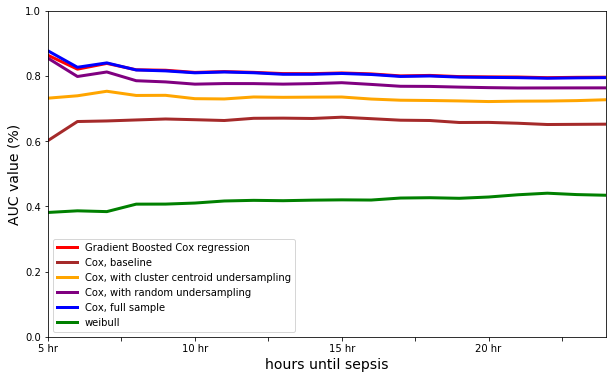

In [1238]:
from sksurv.metrics import cumulative_dynamic_auc

# Predict the testing data
predictions_gbsa8 = gbsa8.predict(X_test)
result = concordance_index_censored(y_test["sepsis"], y_test["event_time_hrs"], predictions_gbsa8)
print("The concordance rate of the gradient boosted model is: {}".format(result[0]))

gb_aucs = cumulative_dynamic_auc(survival_train = y_tr_resampled_df_shuffled_array, 
                       survival_test = y_test_array, 
                       estimate = predictions_gbsa8, 
                       times = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

# Create data frame of the time-dependent AUCs
gb_auc_df = pd.DataFrame({"times":["{} hr".format(i) for i in np.arange(5,25)],
                           "Gradient Boosted Cox regression":gb_aucs[0]})
gb_auc_df.set_index("times", inplace=True)


# Display the time-dependent AUCs from 5 hr to 24 hr
display(np.round(gb_auc_df,3).T)

# Plot this model
fig, ax = plt.subplots(1,1, figsize=(10,6))
gb_auc_df.plot(ax = ax, color = "red", linewidth=3)

# Include lines for the time-dependent AUCs from the three previous models
coxsimple_auc_df.plot(ax = ax, linewidth=3, color="brown")
usample2_auc_df.plot(ax = ax, color = "orange", linewidth=3)
usample_auc_df.plot(ax = ax, color = "purple", linewidth=3)
cox_auc_df.plot(ax = ax, color = "blue", linewidth = 3)
weibull_auc_df.plot(ax = ax, color = "green", linewidth=3)
ax.set_ylim(0.0,1)
ax.set_xlabel("hours until sepsis", fontsize=14)
ax.set_ylabel("AUC value (%)", fontsize=14)
plt.show()

* The performance of the Gradient Boosted model is slightly better than the Cox regression model

## FINAL RESULTS TABLE
* Below we can see the time-dependent AUCs for every fitted model for every hour from 5hours to 24 hours until sepsis
* The Gradient Boosted Model shows the BEST and most ROBUST performance - having the highest concordance rate
* And maintaining at least 80% AUC up to 24 hr. The COx model, however, performs almost just as good!

In [1282]:
complete_results = pd.concat([coxsimple_auc_df, cox_auc_df, weibull_auc_df, usample_auc_df, usample2_auc_df, gb_auc_df], axis=1).T
complete_results['Concordance'] = [0.64, 0.75, 0.44, 0.75, 0.71, 0.78]
np.round(complete_results,2)

times,5 hr,6 hr,7 hr,8 hr,9 hr,10 hr,11 hr,12 hr,13 hr,14 hr,15 hr,16 hr,17 hr,18 hr,19 hr,20 hr,21 hr,22 hr,23 hr,24 hr,Concordance
"Cox, baseline",0.60,0.66,0.66,0.66,0.67,0.67,0.66,0.67,0.67,0.67,0.67,0.67,0.66,0.66,0.66,0.66,0.65,0.65,0.65,0.65,0.64
"Cox, full sample",0.88,0.83,0.84,0.82,0.82,0.81,0.81,0.81,0.80,0.80,0.81,0.80,0.80,0.80,0.80,0.80,0.79,0.79,0.79,0.79,0.75
weibull,0.38,0.39,0.38,0.41,0.41,0.41,0.42,0.42,0.42,0.42,0.42,0.42,0.43,0.43,0.42,0.43,0.44,0.44,0.44,0.43,0.44
"Cox, with random undersampling",0.85,0.80,0.81,0.79,0.78,0.77,0.78,0.78,0.77,0.78,0.78,0.77,0.77,0.77,0.77,0.76,0.76,0.76,0.76,0.76,0.75
"Cox, with cluster centroid undersampling",0.73,0.74,0.75,0.74,0.74,0.73,0.73,0.74,0.73,0.73,0.74,0.73,0.73,0.72,0.72,0.72,0.72,0.72,0.72,0.73,0.71
Gradient Boosted Cox regression,0.86,0.82,0.84,0.82,0.82,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.80,0.80,0.80,0.79,0.80,0.80,0.78


## Feature importance from Gradient Boost
* A positive aspect of the Gradient Boosted Cox Model is the fact that feature importance can be extracted
* Below I plot the feature importances (as proportions, summing to 1 across all features) 

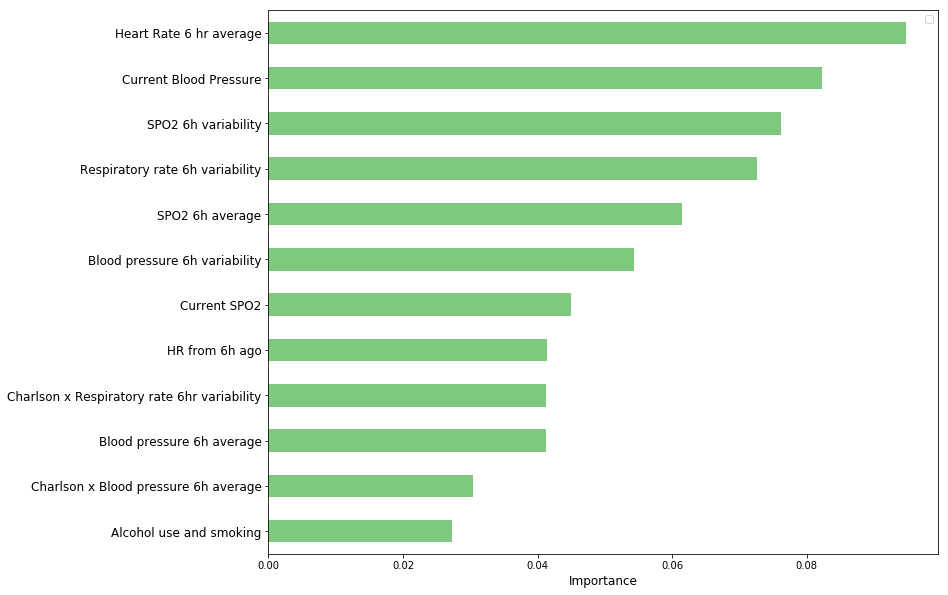

In [1251]:
feature_imps = gbsa8.feature_importances_

fig, ax = plt.subplots(1,1, figsize=(12,10))
GB_feature_importances = pd.DataFrame(feature_imps, index = X_tr_resampled_df_shuffled.columns, columns = ["importance"]).sort_values(by = "importance", ascending=True)
GB_feature_importances.iloc[34:].plot(kind="barh", ax = ax, cmap="Accent")
labels = ["Heart Rate 6 hr average","Current Blood Pressure",
                   "SPO2 6h variability", "Respiratory rate 6h variability",
                   "SPO2 6h average","Blood pressure 6h variability",
                   "Current SPO2", "HR from 6h ago",
          "Charlson x Respiratory rate 6hr variability", "Blood pressure 6h average", "Charlson x Blood pressure 6h average", "Alcohol use and smoking"]
labels.reverse()
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel("Importance", fontsize=12)
ax.legend("")

* We can see that the rate of change in heart rate, mean arterial pressure, and saturated capillary oxygen between the 12th and 6th hours until sepsis were the most important features in the model
* The rate of change was calculated - by taking the 6 hour period between 12 hours and 6 hours until sepsis, for EACH PATIENT, and running a linear regression on that 6 hr window - the value is the coefficient from that linear regression conducted on each patient

# PHASE 6: PLOTTING THE RISK OF SEPSIS OVER TIME FOR AN INDIVIDUAL PATIENT

* Only the **COX REGRESSION MODEL** (model 1) can be used to estimate each individual patient's sepsis risk over time
* The Cox regression model can output, for each patient, their probability of being sepsis free over time (also called the "cumulative survival function". We can simply subtract these values from 1, to get the patient's likelihood of sepsis over time
* The simple Cox model had quite good performance by itself, shown by the blue line in the curve above, being SECOND in performance compared to all the other models, and remaining quite accurate even as time from sepsis increased, so these **survival functions** can be trusted

In [999]:
# I will re-fit the Cox model, then use it to predict

cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train_array)


,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,...,gender*spo2_sd,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*respiratory_rate_sd,heart_rate_coefs,heart_rate_coefs_squared,map_coefs,map_coefs_squared,spo2_coefs,spo2_coefs_squared
patient_id,,,,,,,,,,,,,,,,,,,,,
!!AScBQ5btA,-1.260806,0.907276,1.110646,-0.831246,-5.049391,0.234658,0.237634,1.201476,1.768828,0.840231,...,0.000000,-0.739717,-1.057747,-1.852169,3.094839e+00,-5.593063e-02,0.832463,-1.347305e-02,6.876987,-0.135277
!!G4BY3c@tP,-0.856855,0.013341,1.110646,0.058333,-1.615805,0.335226,0.316846,0.683770,-0.587554,-0.057429,...,0.000000,0.050559,-0.601973,-0.897329,4.659672e-01,-9.573243e-02,0.283473,-4.870257e-02,-0.510627,0.111829
!!rmvMcfsDP,-0.250928,-0.612414,-0.473582,0.000000,0.000000,0.134090,0.950537,-0.920389,-0.301422,-0.690633,...,0.452731,-0.490684,-0.653922,0.141695,5.365612e+00,-1.841978e-02,4.182969,-1.436294e-02,-7.870836,0.027005
!0KLAkVXUQU,-1.664758,1.667121,-0.790427,0.408332,-1.090669,1.202343,-0.792114,-0.016226,-1.294469,0.821607,...,0.296382,0.910504,-0.017982,0.544907,5.598515e-02,6.589298e-03,0.028697,5.687776e-02,-0.442664,0.062820
!0taoFBFtVU,-0.250928,0.058038,0.476955,0.000000,0.000000,-0.193009,0.432062,0.810159,-0.250928,0.154542,...,0.000000,0.000000,0.000000,0.000000,-2.037142e-28,2.337709e-30,-0.041046,-2.105998e-16,0.000000,0.000000


The model features are ['respiratory_rate', 'map', 'spo2', 'heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift', 'heart_rate_mean', 'respiratory_rate_mean', 'map_mean', 'spo2_mean', 'heart_rate_sd', 'respiratory_rate_sd', 'map_sd', 'spo2_sd', 'gender', 'factor1', 'factor2', 'factor3', 'factor4', 'medfactor1', 'medfactor2', 'medfactor3', 'medfactor4', 'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0', 'age', 'bmi', 'charlson_index', 'gender*map_mean', 'gender*map_sd', 'gender*spo2_sd', 'charlson_index*map_mean', 'charlson_index*heart_rate_mean', 'charlson_index*respiratory_rate_sd', 'heart_rate_coefs', 'heart_rate_coefs_squared', 'map_coefs', 'map_coefs_squared', 'spo2_coefs', 'spo2_coefs_squared']


array([  5.        ,   5.01666667,   5.05      , ..., 477.35      ,
       478.03333333, 478.5       ])

array([0.99393148, 0.99383613, 0.99364544, ..., 0.60403196, 0.60403196,
       0.60403196])

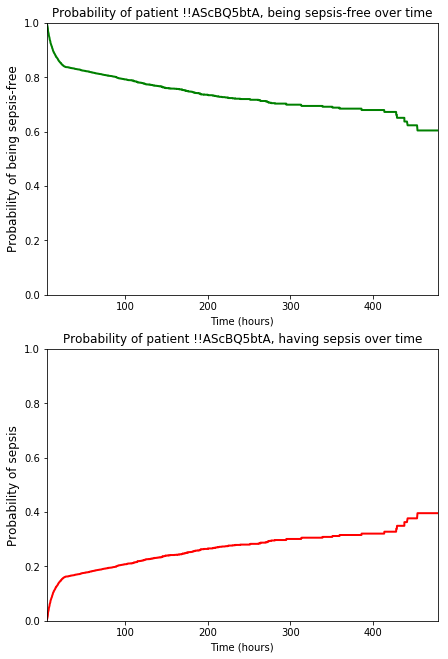

In [1046]:
# I now will plot the survival curve of a specific patient
# To get this curve, the patient must have values for all the features in the model

print("The model features are {}".format(list(X_train.columns)))

# We use the predict_survival_function function to get the sepsis-free likelihood across time for an
# individual patient
# I will use the FIRST patient in the training data as an example

patient = X_train.loc["!!AScBQ5btA",:]
survival_function = (cph.predict_survival_function(patient))

# This function outputs two arrays:
# x - which is the time
# y - which is the probability

# display x
time = survival_function[0].x
display(time)

# display y
prob_survival = survival_function[0].y
display(prob_survival)

# Convert to a data frame
survival_function_df = pd.DataFrame({"Probability":prob_survival}, index = time)
fig, ax = plt.subplots(2,1, figsize=(7,11))

survival_function_df.plot(linewidth=2, ax = ax[0], color="green")
ax[0].set_ylim(0,1)
ax[0].set_ylabel("Probability of being sepsis-free", fontsize = 12)
ax[0].set_xlabel("Time (hours)")
ax[0].set_title("Probability of patient !!AScBQ5btA, being sepsis-free over time")
ax[0].get_legend().remove()

(1-survival_function_df).plot(linewidth=2, ax = ax[1], color="red")
ax[1].set_ylim(0,1)
ax[1].set_ylabel("Probability of sepsis", fontsize = 12)
ax[1].set_xlabel("Time (hours)")
ax[1].set_title("Probability of patient !!AScBQ5btA, having sepsis over time")
ax[1].get_legend().remove()
plt.show()

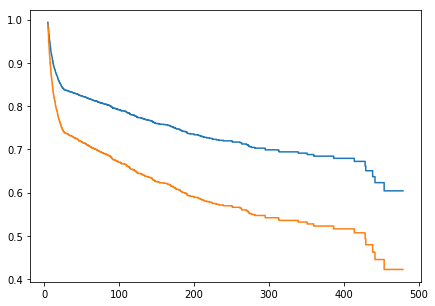

In [1070]:
patient = X_train.loc[["!!AScBQ5btA","!!G4BY3c@tP"],:]
survival_functions = list(enumerate(cph.predict_survival_function(patient)))
fig, ax = plt.subplots(1,1, figsize=(7,5))
for i, c in survival_functions:
    ax.step(c.x, c.y)

In [1115]:
## I will now combine all the steps above into a function - where you can enter a patient ID
# and output their predicted survival function

# The function takes in the data frame and the ID. The data frame must ensure that ID is the INDEX
# It also takes in the Cox regression model (fitted)
# The function can take in a single ID or list of IDs

def plot_survival_function_of_patient(df, patient_id, cox_model):
    patient = df.loc[patient_id,:]
    survival_functions = list(enumerate(cox_model.predict_survival_function(patient)))
    fig, ax = plt.subplots(2,1, figsize=(7,11))
    c_count = 1
    for i, c in survival_functions:
        c_count += 1
        ax[0].step(c.x, c.y)
        ax[0].set_ylim(0,1)
        ax[0].set_ylabel("Probability of being sepsis-free", fontsize = 12)
        ax[0].set_xlabel("Time (hours)")
        ax[0].set_title("Probability of being sepsis-free over time")
        ax[0].legend(["patient {}".format(indiv_patient) for indiv_patient in list(df.index)])

        ax[1].step(c.x, (1-c.y))
        ax[1].set_ylim(0,1)
        ax[1].set_ylabel("Probability of sepsis", fontsize = 12)
        ax[1].set_xlabel("Time (hours)")
        ax[1].set_title("Probability of having sepsis over time")
        ax[1].legend(["patient {}".format(indiv_patient) for indiv_patient in list(df.index)])
    plt.show()

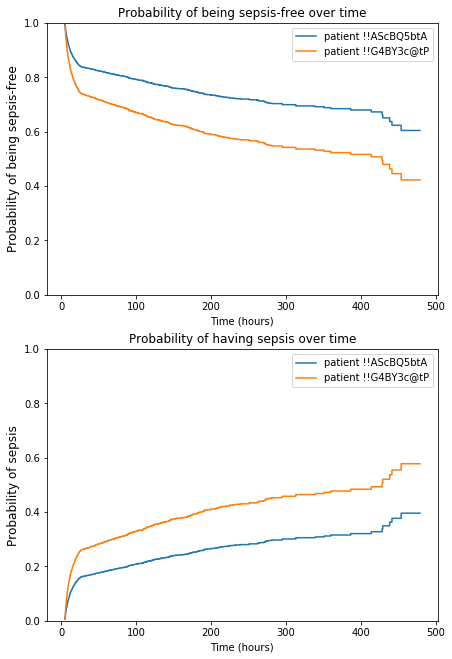

In [1116]:
plot_survival_function_of_patient(df=X_train, 
                                  patient_id = ["!!AScBQ5btA","!!G4BY3c@tP"],
                                  cox_model = cph)

# BONUS (PHASE 7) USE XGBOOST FOR FEATURE IMPORTANCE

* XGBOOST is another Python package that can provide details about feature importance
* An advantage of this package, however, is that it can provide details about the relative importance of features contibuting to an individual's predicted risk score (from the survival algorithm)
* Below I fit a simple XGBOOST model, without any extensive hyperparameter tuning to output both:
    * Overall feature importance
    * Feature importance for an individual patient

In [1252]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

* XGBOOST requires the event column (Sepsis: True, False) and event time columns to be combined into a single column
    * I.e., censored observations (i.e., those that never became septic) should have a negative event time - their event time, multiplied by -1
    * Whereas those that became septic retain their event_time values from before

In [1253]:
# This is how the target variable looks at the moment
display(y_tr_resampled_df_shuffled.head())

,sepsis,event_time_hrs
0,True,139.750000
1,True,8.000000
2,False,54.266667
3,True,8.000000
4,True,8.016667


In [1254]:
# Code below, creates the target variable (as defined above) in the format needed for XGBoost
y_tr_shuffled = y_tr_resampled_df_shuffled.copy()
y_tr_shuffled["event_time_hrs"] = np.where(y_tr_shuffled["sepsis"]==False, y_tr_shuffled["event_time_hrs"]*-1,
                                             y_tr_shuffled["event_time_hrs"])
y_tr_shuffled.drop("sepsis", axis=1, inplace=True)

y_test_shuffled = y_test.copy()
y_test_shuffled["event_time_hrs"] = np.where(y_test_shuffled["sepsis"]==False, y_test_shuffled["event_time_hrs"]*-1,
                                             y_test_shuffled["event_time_hrs"])
y_test_shuffled.drop("sepsis", axis=1, inplace=True)

In [1255]:
# This is how the target variable looks in the format required for XGBOOST
y_tr_shuffled.head()

# we can see that those who were originally "False" for sepsis, now have negative event times

,event_time_hrs
0,139.750000
1,8.000000
2,-54.266667
3,8.000000
4,8.016667


#### Now we will set up the data matrices needed for XGBOOST

In [1256]:
xgb_train = xgboost.DMatrix(X_tr_resampled_df_shuffled, label=y_tr_shuffled)
xgb_test = xgboost.DMatrix(X_test, label=y_test_shuffled)

#### Now we will fit the XGBOOST model to the training data and validate it against the testing data
* We will use this test set to identify the optimal number of trees
* Normally, however, one should use a separate validation set to identify the optimal number of every hyperparameter, and then do a final evaluation using the test set

In [1257]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 20000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.76767
[1000]	test-cox-nloglik:8.47207
[2000]	test-cox-nloglik:8.37638
[3000]	test-cox-nloglik:8.32725
[4000]	test-cox-nloglik:8.29539
[5000]	test-cox-nloglik:8.27462
[6000]	test-cox-nloglik:8.26046
[7000]	test-cox-nloglik:8.24927
[8000]	test-cox-nloglik:8.2392
[9000]	test-cox-nloglik:8.23234
[10000]	test-cox-nloglik:8.22672
[11000]	test-cox-nloglik:8.22273
[12000]	test-cox-nloglik:8.21958
[13000]	test-cox-nloglik:8.21723
[14000]	test-cox-nloglik:8.21604
[15000]	test-cox-nloglik:8.2143
[16000]	test-cox-nloglik:8.21179
[17000]	test-cox-nloglik:8.21098
[18000]	test-cox-nloglik:8.20999
[19000]	test-cox-nloglik:8.20949
[19999]	test-cox-nloglik:8.20948


In [1258]:
# Now, train the model on the full dataset using the 15000 trees (which had the lowest log likelihood above)

X_test_shuffled = X_test.reset_index(drop=True)

xgb_train = xgboost.DMatrix(X_tr_resampled_df_shuffled, label=y_tr_shuffled)
xgb_test = xgboost.DMatrix(X_test, label=y_test_shuffled)

full_X = pd.concat([X_tr_resampled_df_shuffled,X_test_shuffled])
full_y = pd.concat([y_tr_shuffled,y_test_shuffled])

xgb_full = xgboost.DMatrix(full_X, label=full_y)

params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}

model = xgboost.train(params, xgb_full, 20000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:9.14124
[1000]	test-cox-nloglik:8.68051
[2000]	test-cox-nloglik:8.54282
[3000]	test-cox-nloglik:8.46513
[4000]	test-cox-nloglik:8.40786
[5000]	test-cox-nloglik:8.35878
[6000]	test-cox-nloglik:8.31676
[7000]	test-cox-nloglik:8.27946
[8000]	test-cox-nloglik:8.24637
[9000]	test-cox-nloglik:8.21566
[10000]	test-cox-nloglik:8.18677
[11000]	test-cox-nloglik:8.15971
[12000]	test-cox-nloglik:8.13395
[13000]	test-cox-nloglik:8.10984
[14000]	test-cox-nloglik:8.08673
[15000]	test-cox-nloglik:8.06425
[16000]	test-cox-nloglik:8.04236
[17000]	test-cox-nloglik:8.0216
[18000]	test-cox-nloglik:8.00105
[19000]	test-cox-nloglik:7.98141
[19999]	test-cox-nloglik:7.96223


#### Now we can examine feature importance

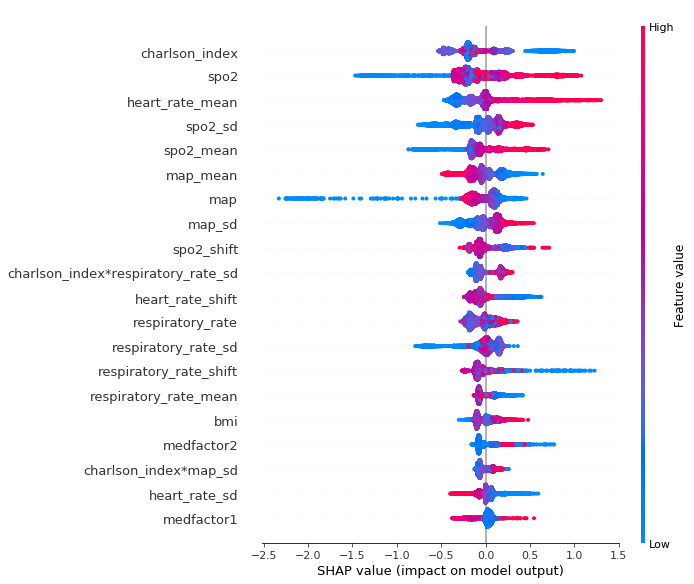

In [1259]:
from shap import TreeExplainer, summary_plot

# set up an explainer object, which will be used to derive feature importance values
explainer = TreeExplainer(model)

# Fit the explainer object to the feature values
shap_values = explainer.shap_values(full_X)

# Display the summary plot
summary_plot(shap_values, full_X)

In [1261]:
full_X.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
0,2.576731,-0.969988,-0.156736,0.000000,0.807903,-1.474993,-0.316846,1.947654,2.004467,-0.288362,-0.262351,0.150991,0.501562,0.529001,0.258703,0.0,-0.351041,0.485335,0.231784,1.180900,-0.283882,2.351916,0.278787,0.997167,0.0,0.0,0.0,1.0,0.0,-0.151275,-0.919508,1.108199,-0.319563,2.158388,-0.290737,0.555830,0.286695,0.586238,0.043622,-0.294630,0.039687,-0.039135,-0.080024,-0.043370,-0.088683,-0.167642
1,1.768828,-0.098401,0.160110,0.174999,2.625683,0.536361,-0.316846,0.348355,0.220348,-0.027631,0.265725,0.111318,1.773096,0.331003,0.327237,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-1.148682,0.652606,-0.880373,0.024326,-0.306683,-0.233937,-1.560986,-0.288090,-0.291406,0.031739,-0.400149,-0.305233,-0.375891,-0.380217,0.330924,0.334732,1.011269
2,-0.247074,-1.685136,-0.473582,-0.291665,-0.113103,-1.720825,0.316846,-0.969000,-0.190522,-0.824723,-0.632004,0.109131,0.042319,0.643874,0.118553,1.0,0.000000,0.000415,0.000000,0.000000,1.359450,-0.219572,0.399865,-0.332756,0.0,0.0,0.0,0.0,0.0,0.094059,0.133587,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.077573,-0.091143,-0.059446,0.011151,0.060562,0.000000,0.000000,0.000000
3,1.364877,-0.321885,-3.325192,0.554164,0.201976,2.033703,-2.851611,0.144190,0.927263,-0.873145,-1.001658,0.344322,0.501562,1.803871,1.586339,1.0,-0.351715,2.393425,4.210041,2.707006,-0.344934,-0.133357,0.291901,-0.180172,0.0,0.0,0.0,0.0,0.0,1.276932,0.197224,3.096771,-2.703929,0.446522,-3.101904,1.553221,4.912528,5.586175,-1.114947,0.184120,-1.279049,2.025647,2.303421,6.272965,7.133166,3.954366
4,0.758950,-0.902943,0.160110,0.025000,-0.201976,-1.315362,1.403173,-1.032889,0.927263,-0.392122,-0.556565,0.020694,0.082456,0.556140,0.520368,0.0,-0.353767,1.197573,0.027445,0.195043,1.930879,-0.548139,1.437306,0.391728,0.0,0.0,0.0,0.0,0.0,1.234160,0.398170,1.108199,-0.434550,-1.144646,-0.616785,0.091378,0.576671,0.616314,-0.483942,-1.274750,-0.686890,0.642217,0.686366,0.711705,0.760630,1.367695


* We can also use this package to view the relative importance of features contributing to a patient's predicted risk score, using the function below:
    * For this particular patient, the most important feature contributing to increases in the patient’s risk score (features coded in red, pointing to the right) was the patient’s heart_rate_mean (average HR in the previous 6hr)
    * The most important feature contributing to reductions in the patient’s risk score (features coded in blue and pointing to the left) was their mean spo2 levels in the previous 6 hours

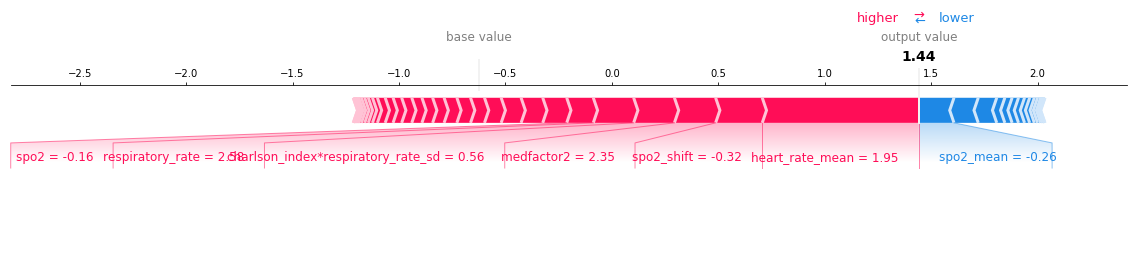

In [1271]:
# Below is an example of viewing feature importance for a specific patient
# The first patient in the dataset

# The function takes in 3 objects
# 1. explainer object - expected_value (i.e., this patient's predicted risk score)
# 2. The shap_value - feature importances for the first patient
# 3. this patient's scores on the features

shap.force_plot(explainer.expected_value, shap_values[0,:], np.round(full_X.iloc[0,:], 2), matplotlib=True)